# Your first graph neural network: Detecting suspicious logins with link prediction

[Graphistry](http://github.com/graphistry/pygraphistry) - Leo Meyerovich, Alex Morrise, Tanmoy Sarkar

[Infosec Jupyterthon 2022](https://infosecjupyterthon.com/2022/agenda.html), December 2022

---

**Alert on & visualize anomalous identity events**
* Demo dataset: 1.6B windows events over 58 days => logins by 12K user over 14K systems
  * adapt to any identity system with logins
  * => Can we identify accounts & computers acting anomalously? Resources being oddly accessed?
  * => Can we spot the red team?
  * => Operations: Identity incident alerting + identity data investigations
  * Community/contact for help handling bigger-than-memory & additional features
* Techniques explored: Graph AI - 
  * RGCN (primary) - powerful with tweaking and in a pipeline
  * UMAP (secondary) - surprisingly effective with little tweaking
* Runs on both CPU + multi-GPU
* Tools: [PyGraphistry[AI]](http://github.com/graphistry/pygraphistry), [DGL](https://www.dgl.ai/) + [PyTorch](https://pytorch.org/), and [NVIDIA RAPIDS](https://rapids.ai/) / [umap-learn](https://github.com/lmcinnes/umap)

---


# Dependencies

## Installs

* installs below
* ... or docker (free): https://hub.docker.com/r/graphistry/graphistry-nvidia
* .... or aws/azure/enterprise (paid) https://www.graphistry.com/get-started 


In [4]:
#! pip install --user --no-input "torch==1.11.0" -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [2]:
! python -c "import torch; print(torch.cuda.is_available())"

True


In [3]:
#! pip install --user dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

In [4]:
#! pip cache remove graphistry
#! pip install --no-cache --user https://github.com/graphistry/pygraphistry/archive/heteroembed.zip

#! pip install --user git+https://github.com/graphistry/pygraphistry.git@fe894b556d078a35d1109c5cb78150818950d66d
#! pip install --user git+https://github.com/graphistry/pygraphistry.git@d7e87c0faf762be5c8779c71caf8da13fae48041
#! pip install --user git+https://github.com/graphistry/pygraphistry.git@6f47e034dcf8e96f241be66aca6a6a6374e7bf83

## Imports

In [5]:
import pandas as pd
import os
from joblib import load, dump
from collections import Counter
import torch
print('torch', torch.__version__)

import numpy as np
import random
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

import graphistry
print('graphistry', graphistry.__version__)

torch 1.11.0+cu113
graphistry 0.28.4+78.g6f47e03


## graphistry

In [6]:
#graphistry.register(
# api=3,
#  protocol="https", server="hub.graphistry.com", client_protocol_hostname='https://hub.graphistry.com',
#  username = '***', password='***'
#)

# Data

**Winlogs demo**

Tested on 40M row sample (2 x RTX), 4M sample (3080 TI), and on a 32 GB CPU box

  - https://csr.lanl.gov/data/cyber1/
  - `auth`: auth.txt.gz (extractable from winlogs)
  - optional: red team data (749 events flagged from auth.txt.gz)

**Custom**

Use any auth data like winlogs

  - load as dataframe `auth`
  - key fields: `auth_type` (arbitrary values), `src_computer` (arbitrary values), `dst_computer` (arbitrary values)
  - other fields nice but not necessary
  - some evaluation steps benefit from a red team but not necessary

### Load identity events + optional red team data

In [7]:
%%time
# total size -> 1051430459/1.05B
auth = pd.read_parquet('data/auth40m.parquet')
print(auth.shape)
auth.head(5)

(40000000, 9)
CPU times: user 11.7 s, sys: 1.88 s, total: 13.6 s
Wall time: 6.14 s


,time,src_domain,dst_domain,src_computer,dst_computer,auth_type,logontype,authentication_orientation,success_or_failure
0,1,ANONYMOUS LOGON@C586,ANONYMOUS LOGON@C586,C1250,C586,NTLM,Network,LogOn,Success
1,1,ANONYMOUS LOGON@C586,ANONYMOUS LOGON@C586,C586,C586,?,Network,LogOff,Success
2,1,C101$@DOM1,C101$@DOM1,C988,C988,?,Network,LogOff,Success
3,1,C1020$@DOM1,SYSTEM@C1020,C1020,C1020,Negotiate,Service,LogOn,Success
4,1,C1021$@DOM1,C1021$@DOM1,C1021,C625,Kerberos,Network,LogOn,Success


###  Red team comparison data (optional)

In [8]:
if True:
    red_team = pd.read_csv('data/redteam.txt', header=None)
else:
    # or whatever comparison set
    # unsupervised method so just for reporting
    red_team = auth.head(749)

print(red_team.shape)
red_team.head(5)

(749, 4)


,0,1,2,3
0,150885,U620@DOM1,C17693,C1003
1,151036,U748@DOM1,C17693,C305
2,151648,U748@DOM1,C17693,C728
3,151993,U6115@DOM1,C17693,C1173
4,153792,U636@DOM1,C17693,C294


In [9]:
cols = auth.columns
anom_label = auth[
    auth[cols[0]].isin(red_team[0]) &
    auth[cols[1]].isin(red_team[1]) & 
    auth[cols[2]].isin(red_team[1]) &
    auth[cols[3]].isin(red_team[2]) &
    auth[cols[4]].isin(red_team[3])
].reset_index()
anom_label

,index,time,src_domain,dst_domain,src_computer,dst_computer,auth_type,logontype,authentication_orientation,success_or_failure
0,29627157,150885,U620@DOM1,U620@DOM1,C17693,C1003,NTLM,Network,LogOn,Success
1,29657341,151036,U748@DOM1,U748@DOM1,C17693,C305,NTLM,Network,LogOn,Success
2,29776464,151648,U748@DOM1,U748@DOM1,C17693,C728,NTLM,Network,LogOn,Success
3,29850298,151993,U6115@DOM1,U6115@DOM1,C17693,C1173,NTLM,Network,LogOn,Success
4,30188660,153792,U636@DOM1,U636@DOM1,C17693,C294,NTLM,Network,LogOn,Success
5,30425163,155219,U748@DOM1,U748@DOM1,C17693,C5693,NTLM,Network,LogOn,Success
6,30458238,155399,U748@DOM1,U748@DOM1,C17693,C152,NTLM,Network,LogOn,Success
7,30468055,155460,U748@DOM1,U748@DOM1,C17693,C2341,NTLM,Network,LogOn,Success
8,30489739,155591,U748@DOM1,U748@DOM1,C17693,C332,NTLM,Network,LogOn,Success
9,30662347,156658,U748@DOM1,U748@DOM1,C17693,C4280,NTLM,Network,LogOn,Success


In [10]:
anom_label['RED'] = 1

# enrich the edges with the red team data
ind = auth.index.isin(anom_label['index'])
auth.loc[ind, 'RED'] = 1
auth.loc[~ind, 'RED'] = 0

print('# red', auth['RED'].sum())

# let's see the bad infiltration point
auth[auth.src_computer == 'C17693'].sample(10)

# red 11.0


,time,src_domain,dst_domain,src_computer,dst_computer,auth_type,logontype,authentication_orientation,success_or_failure,RED
39201345,206645,U8350@DOM1,U8350@DOM1,C17693,C467,NTLM,Network,LogOn,Success,0.0
29776464,151648,U748@DOM1,U748@DOM1,C17693,C728,NTLM,Network,LogOn,Success,1.0
38906146,205356,U748@DOM1,U748@DOM1,C17693,C3007,NTLM,Network,LogOn,Success,0.0
30188660,153792,U636@DOM1,U636@DOM1,C17693,C294,NTLM,Network,LogOn,Success,1.0
28845530,147076,U8009@C926,U8009@C926,C17693,C926,NTLM,Network,LogOn,Fail,0.0
28860620,147141,U8009@C1759,U8009@C1759,C17693,C1759,NTLM,Network,LogOn,Fail,0.0
39208487,206678,U8350@DOM1,U8350@DOM1,C17693,C529,NTLM,Network,LogOn,Success,0.0
39126261,206295,U8350@DOM1,U8350@DOM1,C17693,C529,NTLM,Network,LogOn,Success,0.0
29620541,150847,U620@DOM1,U620@DOM1,C17693,C1759,NTLM,Network,LogOn,Success,0.0
28359627,145015,U1723@C1759,U1723@C1759,C17693,C1759,NTLM,Network,LogOn,Fail,0.0


### Quick viz

[viz](https://hub.graphistry.com/graph/graph.html?dataset=7f5cd746e6944a739a8627bd3a8892fb&play=0)

In [11]:
graphistry.edges(
    pd.concat([anom_label, auth.sample(100000)], ignore_index=True, sort=False),
    'src_computer', 'dst_computer'
).plot()

### Down-sample (optional)

In [12]:
if True:
    SAMPLE_PERCENT = 0.10
    print(f'sampling down {SAMPLE_PERCENT * 100}%')
    all_auth = auth
    all_auth_unred = all_auth[ all_auth.RED == 0 ]
    all_auth_red = all_auth[ all_auth.RED == 1 ]
    auth = pd.concat(
        [
            all_auth_unred.sample(frac=SAMPLE_PERCENT, random_state=RANDOM_SEED),
            all_auth_red
        ],
        ignore_index=True,
        sort=False)
    print(auth.shape)

sampling down 10.0%
(4000010, 10)


In [13]:
# see the data and if everything was flagged (since this is timelike..)
auth[
    auth['src_computer'].isin(set(red_team[2])) & 
    auth['dst_computer'].isin(set(red_team[3]))
].reset_index()

,index,time,src_domain,dst_domain,src_computer,dst_computer,auth_type,logontype,authentication_orientation,success_or_failure,RED
0,1467943,206678,U8350@DOM1,U8350@DOM1,C17693,C529,NTLM,Network,LogOn,Success,0.0
1,3999999,150885,U620@DOM1,U620@DOM1,C17693,C1003,NTLM,Network,LogOn,Success,1.0
2,4000000,151036,U748@DOM1,U748@DOM1,C17693,C305,NTLM,Network,LogOn,Success,1.0
3,4000001,151648,U748@DOM1,U748@DOM1,C17693,C728,NTLM,Network,LogOn,Success,1.0
4,4000002,151993,U6115@DOM1,U6115@DOM1,C17693,C1173,NTLM,Network,LogOn,Success,1.0
5,4000003,153792,U636@DOM1,U636@DOM1,C17693,C294,NTLM,Network,LogOn,Success,1.0
6,4000004,155219,U748@DOM1,U748@DOM1,C17693,C5693,NTLM,Network,LogOn,Success,1.0
7,4000005,155399,U748@DOM1,U748@DOM1,C17693,C152,NTLM,Network,LogOn,Success,1.0
8,4000006,155460,U748@DOM1,U748@DOM1,C17693,C2341,NTLM,Network,LogOn,Success,1.0
9,4000007,155591,U748@DOM1,U748@DOM1,C17693,C332,NTLM,Network,LogOn,Success,1.0


# Configure
### Identify src vs dst columns

The RGCN connects homogeneous nodes (ex: computers) through heterogeneous relationships (ex: event types)

In [14]:
SRC = 'src_computer'
DST = 'dst_computer'
#SRC = 'src_domain'
#DST = 'dst_domain'

NODE = 'computer'


##DST_OPP = 'dst_domain'
#SRC_OPP = 'src_computer'
#DST_OPP = 'dst_computer'

# Feature engineering

## Node features - optional enrichment & event summaries

* Provided: If node features are available, handle here
* Aggregated: We gather some here from the incoming vs outgoing edges
* Graph analytics: Often useful to also add graph statistics here too (pagerank, centrality, ...)

For bigger-than-memory, use dask (cpu) or dask_cudf (gpu)

In [15]:
mode = pd.Series.mode
outgoing_conn_stats = auth[:1000].groupby([SRC]).agg({
    'time': ['min', 'max', 'mean'],
    'dst_domain': [mode, 'count'],
    'dst_computer': [mode, 'count'],
    'auth_type': [mode, 'count'],
    'logontype': [mode, 'count'],
    'authentication_orientation': [mode, 'count'],
    'success_or_failure': [mode, 'count']
})
outgoing_conn_stats.columns = [f'out_{c[0]}_{c[1]}' for c in outgoing_conn_stats.columns]

mode = pd.Series.mode
incoming_conn_stats = auth[:1000].groupby([DST]).agg({
    'time': ['min', 'max', 'mean'],
    'src_domain': [mode, 'count'],
    'src_computer': [mode, 'count'],
    'auth_type': [mode, 'count'],
    'logontype': [mode, 'count'],
    'authentication_orientation': [mode, 'count'],
    'success_or_failure': [mode, 'count']
})
incoming_conn_stats.columns = [f'in_{c[0]}_{c[1]}' for c in incoming_conn_stats.columns]


# outgoing_conn_stats
# incoming_conn_stats

nodes = pd.DataFrame({NODE: pd.concat([auth[SRC], auth[DST]]).unique()})
nodes = nodes.merge(outgoing_conn_stats, how='left', left_on=NODE, right_on=SRC)
nodes = nodes.merge(incoming_conn_stats, how='left', left_on=NODE, right_on=DST)
for c in ['min', 'max', 'mean']:
    nodes[f'out_time_{c}'] = nodes[f'out_time_{c}'].fillna(0.)
    nodes[f'in_time_{c}'] = nodes[f'in_time_{c}'].fillna(0.)


def flatten_lst(o):
    if isinstance(o, list):
        return o[0]
    if isinstance(o, str):
        return o
    return ''


for c in ['mode']:
    for k in ['dst_domain', 'dst_computer', 'auth_type', 'logontype', 'authentication_orientation', 'success_or_failure']:
        nodes[f'out_{k}_{c}'] = nodes[f'out_{k}_{c}'].apply(flatten_lst)
    for k in ['src_domain', 'src_computer', 'auth_type', 'logontype', 'authentication_orientation', 'success_or_failure']:
        nodes[f'in_{k}_{c}'] = nodes[f'in_{k}_{c}'].apply(flatten_lst)

for c in ['count']:
    for k in ['dst_domain', 'dst_computer', 'auth_type', 'logontype', 'authentication_orientation', 'success_or_failure']:
        nodes[f'out_{k}_{c}'] = nodes[f'out_{k}_{c}'].fillna(0)
    for k in ['src_domain', 'src_computer', 'auth_type', 'logontype', 'authentication_orientation', 'success_or_failure']:
        nodes[f'in_{k}_{c}'] = nodes[f'in_{k}_{c}'].fillna(0)

print(nodes.shape)
nodes.sample(10)

(10887, 31)


,computer,out_time_min,out_time_max,out_time_mean,out_dst_domain_mode,out_dst_domain_count,out_dst_computer_mode,out_dst_computer_count,out_auth_type_mode,out_auth_type_count,...,in_src_computer_mode,in_src_computer_count,in_auth_type_mode,in_auth_type_count,in_logontype_mode,in_logontype_count,in_authentication_orientation_mode,in_authentication_orientation_count,in_success_or_failure_mode,in_success_or_failure_count
1157,C7249,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
10714,C10703,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
3872,C6943,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
8832,C7472,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
10732,C9999,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
2885,C1555,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
1701,C5796,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
7597,C11731,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
5051,C7485,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0
8477,C1548,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,,0.0,,0.0,,0.0,,0.0,,0.0


## Node features - auto-generation & compression

In [16]:
gg = graphistry.nodes(nodes, NODE)
g_sample = gg.featurize(
    cardinality_threshold=len(auth)+1,  # avoid topic modeling on high-cardinality cols
    min_words=len(auth)+1,  # avoid topic modeling on high-cardinality cols
)

X = g_sample._node_features
#print('memory', X.memory_usage())
print('sample low cardinality')
{
    c: X[c].nunique()
    for c in X.columns[:10] #sampled, good to manually inspect for nice columns
    if X[c].nunique() < 10
}

sample low cardinality


{'out_dst_domain_mode_': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C1065': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C1628': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C17899': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C457': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C467': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C528': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C529': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C586': 2,
 'out_dst_domain_mode_ANONYMOUS LOGON@C625': 2}

In [17]:
sums = X.sum(0)
good_feats = [c for c in X.columns if sums[c] > 10 or 'type' in c]

print('#total feats', len(X.columns))
print('#good feats (decent cardinality)', len(good_feats))
print(X[good_feats].sum(0).astype(int))
X[good_feats].sample(5)

#total feats 889
#good feats (decent cardinality) 74
out_dst_domain_mode_                        10411
out_dst_domain_mode_ANONYMOUS LOGON@C586       16
out_dst_computer_mode_                      10408
out_dst_computer_mode_C1065                    25
out_dst_computer_mode_C2106                    16
                                            ...  
in_src_computer_count                        1000
in_auth_type_count                           1000
in_logontype_count                           1000
in_authentication_orientation_count          1000
in_success_or_failure_count                  1000
Length: 74, dtype: int64


,out_dst_domain_mode_,out_dst_domain_mode_ANONYMOUS LOGON@C586,out_dst_computer_mode_,out_dst_computer_mode_C1065,out_dst_computer_mode_C2106,out_dst_computer_mode_C457,out_dst_computer_mode_C467,out_dst_computer_mode_C528,out_dst_computer_mode_C529,out_dst_computer_mode_C586,...,out_success_or_failure_count,in_time_min,in_time_max,in_time_mean,in_src_domain_count,in_src_computer_count,in_auth_type_count,in_logontype_count,in_authentication_orientation_count,in_success_or_failure_count
3579,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6966,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4599,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,199787.0,199787.0,199787.0,1.0,1.0,1.0,1.0,1.0,1.0
5072,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Edge features - Multi-column relationship types (optional)

### Untyped

Useful for emulating a vanilla GCN via RGCN

In [18]:
df = auth
df2a = df.assign(constant_edge_label=1)

### Combos: reln as combined (`auth_type` x `logontype`)

In [19]:
df2 = df2a.assign(reln=df.auth_type + '::' + df.logontype)
df2.reln.sample(5)

243922     Kerberos::Network
835852     Kerberos::Network
865963                  ?::?
3562087           ?::Network
1788835    Kerberos::Network
Name: reln, dtype: object

### Compression: reln as topic model over many columns or high-cardinality columns

To prevent too many relationship types blowing out memory, we can use tricks like topic models to cut down to a more reasonable set


In [20]:
g_runiq = graphistry.nodes(df2.drop_duplicates(subset=['reln']))
g_featurized = g_runiq.featurize(X=['reln'], min_words=1000000, n_topics=15, cardinality_threshold=2)
X = g_featurized._node_features
X.sample(5)

,"reln: ntlm, wave, batch","reln: batch, ntlm, wave","reln: negotiate, ntlm, wave","reln: ntlm, wave, interactive","reln: microsoft_authentication_packa, microsoft_authentication_pack, microsoft_authentication_pac","reln: remoteinteractive, interactive, ntlm","reln: microsoft_authentication_package_v1, microsoft_authentication_package_v, microsoft_authentication_package_","reln: kerberos, network, ntlm","reln: newcredentials, ntlm, wave","reln: microsoft_authentication_package_v1_0, microsoft_authentication_package_v1_, microsoft_authentication_package_v1","reln: networkcleartext, ntlm, wave","reln: service, ntlm, wave","reln: unlock, wave, ntlm","reln: cachedinteractive, interactive, ntlm","reln: microsoft_authentica, microsoft_authentication_pa, microsoft_authentication_pac"
339375,0.148557,0.056838,0.057913,0.152160,0.185454,0.174556,0.280331,0.054524,0.060744,70.747278,0.053815,0.058804,0.056780,0.522876,0.139371
7814,0.052674,0.055471,11.718799,1.717323,0.053624,25.518031,0.052828,0.054558,0.062141,0.060254,0.071018,0.085292,0.057539,0.137766,0.052682
683631,0.050558,0.053184,0.058496,0.053717,0.050803,0.051884,0.050711,0.051522,0.050903,0.050871,0.051656,0.052714,15.020143,0.052309,0.050528
237141,0.206005,0.056884,0.057404,0.057193,8.189937,0.054009,51.363086,0.262343,0.072549,0.211270,0.085901,0.055594,0.054310,0.057548,1.465967
4217,0.054613,0.074897,0.057616,0.056144,0.056909,0.056405,0.055506,0.066759,22.429283,0.053986,0.059091,0.056387,0.054664,0.058439,0.059300


In [21]:
X_df2, y_df2 = g_featurized.transform(df2, ydf=None, kind='nodes')
reln_topic = pd.Series([ X_df2.columns[k] for k in X_df2.values.argmax(1) ])
df3 = df2.assign(reln_topic=reln_topic)
reln_topic.sample(10)

392537     reln: kerberos, network, ntlm
3497381    reln: kerberos, network, ntlm
387017     reln: kerberos, network, ntlm
2356261    reln: kerberos, network, ntlm
1169846    reln: kerberos, network, ntlm
3038088    reln: kerberos, network, ntlm
2420173    reln: kerberos, network, ntlm
2441144          reln: batch, ntlm, wave
3933167    reln: kerberos, network, ntlm
2362703    reln: kerberos, network, ntlm
dtype: object

### Comparison

Any of these may be interesting as feature columns

In [22]:
print({
    v: df3[v].nunique()
    for v in ['constant_edge_label', 'auth_type', 'logontype', 'reln', 'reln_topic']
})

df3[['constant_edge_label', 'auth_type', 'logontype', 'reln', 'reln_topic']].sample(10)

{'constant_edge_label': 1, 'auth_type': 17, 'logontype': 10, 'reln': 38, 'reln_topic': 15}


,constant_edge_label,auth_type,logontype,reln,reln_topic
3181846,1,?,?,?::?,"reln: batch, ntlm, wave"
3637183,1,NTLM,Network,NTLM::Network,"reln: kerberos, network, ntlm"
3527822,1,Kerberos,Network,Kerberos::Network,"reln: kerberos, network, ntlm"
2972171,1,Kerberos,Network,Kerberos::Network,"reln: kerberos, network, ntlm"
1844173,1,?,Network,?::Network,"reln: kerberos, network, ntlm"
3405729,1,?,Network,?::Network,"reln: kerberos, network, ntlm"
703185,1,Kerberos,Network,Kerberos::Network,"reln: kerberos, network, ntlm"
3827554,1,?,Network,?::Network,"reln: kerberos, network, ntlm"
2057222,1,?,Network,?::Network,"reln: kerberos, network, ntlm"
2072045,1,Kerberos,Network,Kerberos::Network,"reln: kerberos, network, ntlm"


# Model training

Graph: `(computer)-[event]->(computer)`

Edge relationship variants:  untyped, `auth_type`, `auth_type::logontype`, topic model `auth_type::logontype`
Node feature variants: none, sampled


## Graph shape

In [23]:
# simple: graphistry.edges(df3, SRC, DST)

g = (
    graphistry
    .nodes(pd.concat([nodes, X], axis=1), NODE) ## adds computed node features
    .edges(df3, SRC, DST)
)

## Node & edge data

In [24]:
print(g._nodes.shape)
g._nodes.sample(5)

(10904, 46)


,computer,out_time_min,out_time_max,out_time_mean,out_dst_domain_mode,out_dst_domain_count,out_dst_computer_mode,out_dst_computer_count,out_auth_type_mode,out_auth_type_count,...,"reln: remoteinteractive, interactive, ntlm","reln: microsoft_authentication_package_v1, microsoft_authentication_package_v, microsoft_authentication_package_","reln: kerberos, network, ntlm","reln: newcredentials, ntlm, wave","reln: microsoft_authentication_package_v1_0, microsoft_authentication_package_v1_, microsoft_authentication_package_v1","reln: networkcleartext, ntlm, wave","reln: service, ntlm, wave","reln: unlock, wave, ntlm","reln: cachedinteractive, interactive, ntlm","reln: microsoft_authentica, microsoft_authentication_pa, microsoft_authentication_pac"
554,C1476,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8324,C15964,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10540,C5684,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1933,C12857,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2428,C14040,0.0,0.0,0.0,,0.0,,0.0,,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
print(g._edges.shape)
g._edges.sample(5)

(4000010, 13)


,time,src_domain,dst_domain,src_computer,dst_computer,auth_type,logontype,authentication_orientation,success_or_failure,RED,constant_edge_label,reln,reln_topic
2919189,165394,C1620$@DOM1,C1620$@DOM1,C1621,C528,?,?,TGS,Success,0.0,1,?::?,"reln: batch, ntlm, wave"
3926399,45204,ANONYMOUS LOGON@C586,ANONYMOUS LOGON@C586,C2654,C586,NTLM,Network,LogOn,Success,0.0,1,NTLM::Network,"reln: kerberos, network, ntlm"
390234,14983,U6@DOM1,U6@DOM1,C61,C61,?,Network,LogOff,Success,0.0,1,?::Network,"reln: kerberos, network, ntlm"
2017626,47099,C1085$@DOM1,C1085$@DOM1,C467,C467,?,Network,LogOff,Success,0.0,1,?::Network,"reln: kerberos, network, ntlm"
3126304,138945,ANONYMOUS LOGON@C2106,ANONYMOUS LOGON@C2106,C8416,C2106,NTLM,Network,LogOn,Success,0.0,1,NTLM::Network,"reln: kerberos, network, ntlm"


## Train

In [26]:
# If GPU/CPU RAM low, try to free up
if True:
    g.reset_caches()
    torch.cuda.empty_cache()

Resumable -- want to run for more epochs? Just run the cell again 🚀

In [36]:
is_gpu = True

# CPU + GPU both work!
# GPUs tested:
#   20-40M rows: 2 x GPUs (24 GB GPU RAM ea)
#   4M rows: 1 x 3080 Ti GPU  (12 GB GPU RAM)
# CPU: 32 GB RAM

dev0 = 'cpu'
if is_gpu:
    dev0 = 'cuda'

g2 = g.embed(

    #relation='constant_edge_label',
    #relation='auth_type',
    #relation='reln',
    #relation='reln_topic'

    #proto='RotatE',
    #proto='DistMult', ##default
    #proto='TransE',

    #if nodes: g.nodes(...), then g.embed(use_feats=True, X=['col1', ..], and optionally, y=['col10', ..]
    use_feat=True, #nodes with attributes
    X=[NODE] + good_feats,
    #cardinality_threshold=len(g._edges)+1, #avoid topic modeling on high-cardinality cols
    #min_words=len(g._edges)+1,  #avoid topic modeling on high-cardinality cols

    ##n_topics=21,

    train_split=0.99,
    batch_size=32,
    embedding_dim=32,
    evaluate=True,
    lr=0.004,  # 0.002, ..
    device=dev0,

    epochs=20,  # 20 if no features & 4M samples, 60+ if node features: 
                # increase/rerun till score 85%+
)

Preprocessing embedding data
--Splitting data
--num_nodes: 10888,                 num_relationships: 1
Training embedding
--Reusing previous model


epoch: 2, loss: 0.3476, score: 72.2907%:   5%|▌         | 1/20 [00:05<01:43,  5.44s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 3, loss: 0.3514, score: 73.3732%:  10%|█         | 2/20 [00:11<01:38,  5.47s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 4, loss: 0.3443, score: 72.9257%:  15%|█▌        | 3/20 [00:16<01:32,  5.47s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 5, loss: 0.3415, score: 74.2381%:  20%|██        | 4/20 [00:21<01:26,  5.43s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 6, loss: 0.3414, score: 73.5282%:  25%|██▌       | 5/20 [00:27<01:21,  5.42s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 7, loss: 0.3446, score: 72.3357%:  30%|███       | 6/20 [00:32<01:15,  5.40s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 8, loss: 0.3437, score: 75.5781%:  35%|███▌      | 7/20 [00:38<01:10,  5.42s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 9, loss: 0.3354, score: 72.5582%:  40%|████      | 8/20 [00:43<01:05,  5.48s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 10, loss: 0.3415, score: 72.4707%:  45%|████▌     | 9/20 [00:49<01:00,  5.48s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 11, loss: 0.3326, score: 73.1382%:  50%|█████     | 10/20 [00:54<00:54,  5.44s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 12, loss: 0.3382, score: 74.3431%:  55%|█████▌    | 11/20 [00:59<00:48,  5.41s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 13, loss: 0.3347, score: 73.6782%:  60%|██████    | 12/20 [01:05<00:43,  5.41s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 14, loss: 0.3373, score: 73.6907%:  65%|██████▌   | 13/20 [01:10<00:37,  5.40s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 15, loss: 0.3312, score: 73.1132%:  70%|███████   | 14/20 [01:16<00:32,  5.41s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 16, loss: 0.3351, score: 74.1356%:  75%|███████▌  | 15/20 [01:21<00:27,  5.45s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 17, loss: 0.3237, score: 74.9081%:  80%|████████  | 16/20 [01:27<00:21,  5.45s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 18, loss: 0.3369, score: 73.6882%:  85%|████████▌ | 17/20 [01:32<00:16,  5.45s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 19, loss: 0.3278, score: 72.9782%:  90%|█████████ | 18/20 [01:37<00:10,  5.43s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 20, loss: 0.3266, score: 73.7532%:  95%|█████████▌| 19/20 [01:43<00:05,  5.45s/it]

Evaluating...
--took 0.01 minutes to evaluate


epoch: 20, loss: 0.3261, score: 73.33%: 100%|██████████| 20/20 [01:49<00:00,  5.45s/it]  

Evaluating...
--took 0.01 minutes to evaluate


## Inspect model

In [27]:
g2._embed_model

HeteroEmbed(
  (rgcn): RGCNEmbed(
    (emb): Embedding(10888, 32)
    (rgc1): RelGraphConv(
      (linear_r): TypedLinear(in_size=32, out_size=32, num_types=1, regularizer=bdd, num_bases=32)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (rgc2): RelGraphConv(
      (linear_r): TypedLinear(in_size=32, out_size=32, num_types=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [28]:
g2._embed_model.relational_embedding.shape

torch.Size([1, 32])

In [29]:
(
    g2._embed_model.relational_embedding.min(),
    g2._embed_model.relational_embedding.mean(),
    g2._embed_model.relational_embedding.max()
)

(tensor(-0.4868, grad_fn=<MinBackward1>),
 tensor(0.0236, grad_fn=<MeanBackward0>),
 tensor(0.4513, grad_fn=<MaxBackward1>))

## Explore hits

In [28]:
def to_cpu(tensor):
    """
    Helper for switching between is_gpu to avoid coercion errors
    """
    if is_gpu:
        return tensor.cpu()
    else:
        return tensor

In [37]:
%%time
score2 = g2._score(g2._triplets)
df['score'] = to_cpu(score2).numpy()
type(score2), to_cpu(score2).numpy().min(), to_cpu(score2).numpy().max()

CPU times: user 998 ms, sys: 27.8 ms, total: 1.03 s
Wall time: 744 ms


(torch.Tensor, 3.049316e-08, 0.99901354)

In [38]:
anom_edges2 = df[to_cpu(score2).numpy() < 0.03]

print('number within threshold', anom_edges2.shape)

anom_edges2[
    anom_edges2['time'].isin(set(red_team[0])) &
    anom_edges2['src_computer'].isin(set(red_team[2])) & 
    anom_edges2['dst_computer'].isin(set(red_team[3]))
].reset_index()

number within threshold (924, 11)


,index,time,src_domain,dst_domain,src_computer,dst_computer,auth_type,logontype,authentication_orientation,success_or_failure,RED,score
0,4000000,151036,U748@DOM1,U748@DOM1,C17693,C305,NTLM,Network,LogOn,Success,1.0,0.006004
1,4000001,151648,U748@DOM1,U748@DOM1,C17693,C728,NTLM,Network,LogOn,Success,1.0,0.003731
2,4000003,153792,U636@DOM1,U636@DOM1,C17693,C294,NTLM,Network,LogOn,Success,1.0,0.020784
3,4000004,155219,U748@DOM1,U748@DOM1,C17693,C5693,NTLM,Network,LogOn,Success,1.0,0.023513
4,4000005,155399,U748@DOM1,U748@DOM1,C17693,C152,NTLM,Network,LogOn,Success,1.0,0.000488
5,4000007,155591,U748@DOM1,U748@DOM1,C17693,C332,NTLM,Network,LogOn,Success,1.0,0.006469
6,4000008,156658,U748@DOM1,U748@DOM1,C17693,C4280,NTLM,Network,LogOn,Success,1.0,0.005589
7,4000009,210086,U748@DOM1,U748@DOM1,C18025,C1493,NTLM,Network,LogOn,Success,1.0,0.009605


In [31]:
srcindx = df.src_computer.isin(anom_label.src_computer)
dstindx = df.dst_computer.isin(anom_label.dst_computer)
srcscore = score2.cpu().numpy()[srcindx]
dstscore = score2.cpu().numpy()[dstindx]

In [ ]:
sdf = df[srcindx | dstindx]
sdf

In [33]:
# one can see from this graph that it is not entirely obvious that red team nodes are where they are, and certianly 
gsmall = graphistry.edges(sdf, 'src_computer','dst_computer')
url = gsmall.plot(render=False)
url

'https://hub.graphistry.com/graph/graph.html?dataset=3f5ec495b70449abad38834abafbccfc&type=arrow&viztoken=b274cd2e-e255-49bb-a5ce-34c6c9d54357&usertag=23693246-pygraphistry-0.28.4+78.g6f47e03&splashAfter=1669998005&info=true'

(array([ 43.,  77., 107., 107., 170.,  31., 243., 160.,   0.,  39.]),
 array([0.01555263, 0.10742634, 0.19930004, 0.29117373, 0.38304743,
        0.47492114, 0.5667948 , 0.6586685 , 0.7505422 , 0.8424159 ,
        0.93428963], dtype=float32),
 <BarContainer object of 10 artists>)

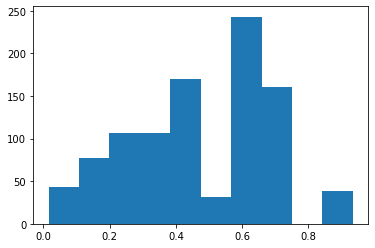

In [35]:
import matplotlib.pyplot as plt
import numpy as np
s = np.r_[srcscore, dstscore]
plt.hist(s)

# Are simpler methods better?
## Maybe conditional probability `p(dst_computer | src_computer)` can give us good histograms to tease out red team nodes?

In [53]:
def conditional_probability(x, given, df):
    """conditional probability function over categorical variables
       p(x|given) = p(x,given)/p(given)
    Args:
        x: the column variable of interest given the column 'given'
        given: the variabe to fix constant
        df: dataframe with columns [given, x]
    Returns:
        pd.DataFrame: the conditional probability of x given the column 'given'
    """
    return df.groupby([given])[x].apply(lambda g: g.value_counts()/len(g))


In [54]:
auth.src_computer.nunique(), auth.dst_computer.nunique()

(10475, 10313)

In [55]:
pd.concat([auth.src_computer, auth.dst_computer]).nunique()

10887

In [56]:
cnp = conditional_probability('dst_computer', given='src_computer', df=auth)
cnp

src_computer       
C1            C1       0.438462
              C529     0.130769
              C625     0.092308
              C586     0.080769
              U25      0.076923
                         ...   
C9997         C1065    0.010256
              C585     0.010256
              U7       0.005128
              C801     0.005128
              C2162    0.005128
Name: dst_computer, Length: 136119, dtype: float64

## Conditional Graph

[Demo]('https://hub.graphistry.com/graph/graph.html?dataset=03bcc2f71a054a9c84fa5ce881f462bd&play=0')

In [57]:
x=SRC
given=DST
condprobs = conditional_probability(x, given, df=auth)

cprob = pd.DataFrame(list(condprobs.index), columns=[given, x])
cprob['_probs'] = condprobs.values

In [58]:
# now enrich the edges dataframe with the redteam data
indx = cprob.src_computer.isin(anom_label[SRC]) & cprob[DST].isin(anom_label[DST])
cprob.loc[indx, 'red'] = 1
cprob.loc[~indx, 'red'] = 0

In [42]:
cg = graphistry.edges(cprob, x, given).bind(edge_weight='_probs')
cg.plot(render=False)

'https://hub.graphistry.com/graph/graph.html?dataset=03bcc2f71a054a9c84fa5ce881f462bd&type=arrow&viztoken=abe69b16-c979-4ee5-b954-f6214d2d6b91&usertag=23693246-pygraphistry-refs/pull/408/head&splashAfter=1669918110&info=true'

## Learning
The conditional graph shows that most of the edge probabilities are between 4e-7 and 0.03, whose bucket contains 91k edges. Thus the chances of finding the red team edges are 10/91000 ~ 1e-4 -- slim indeed

In [43]:
# let's repeat but with reverse conditional
x='src_computer'
given='dst_computer'
condprobs2 = conditional_probability(x, given, df=auth)

cprob2 = pd.DataFrame(list(condprobs2.index), columns=[given, x])
cprob2['_probs'] = condprobs2.values

In [44]:
# now enrich the edges dataframe with the redteam data
indx = cprob2.src_computer.isin(anom_label.src_computer) & cprob2.dst_computer.isin(anom_label.dst_computer)
cprob2.loc[indx, 'red'] = 1
cprob2.loc[~indx, 'red'] = 0

## Can we do simple std analysis on red vs not?

Not really

In [56]:
red=X[:11].std(0).values
red

array([6.69291932e+00, 6.94233955e+00, 4.03406261e+00, 1.24375581e+00,
       8.19816652e+00, 5.34599137e+00, 8.55273272e+00, 8.82849580e+00,
       5.97048788e+00, 7.98474697e-01, 7.14580528e-03, 4.22057963e-02,
       2.00462442e-02, 2.38532804e+00, 8.04956952e-02])

In [57]:
import numpy as np
indx = np.random.choice(range(11, len(X)), 11)
rand = X.iloc[indx].std(0).values
rand

array([2.72630555e-01, 4.27446082e+00, 1.50943836e-02, 2.35438425e+01,
       7.47794986e-02, 1.66500055e-01, 2.07862744e+00, 1.97366326e-01,
       1.64508509e-02, 6.49012753e-01, 6.75271878e+00, 1.20960431e+01,
       7.55023721e+00, 3.07596829e+01, 2.12004662e+01])

In [58]:
blue=X[11:].std(0).values
blue

array([11.94419565,  3.63960234,  2.87543166, 18.48754619,  3.58461871,
        5.26787065, 20.78975583,  6.13758242,  2.29442998,  8.55447084,
        5.97436329,  7.97298694,  8.26999525, 14.63120211, 13.53291024])

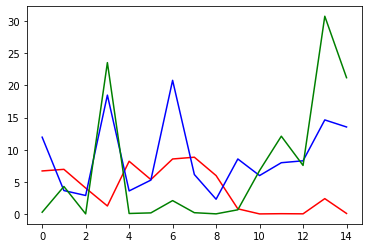

In [61]:
from matplotlib import pyplot as plt


#plt.plot(red/blue)
plt.plot(red, c='r')
plt.plot(blue, c='b')
plt.plot(rand, c='g')

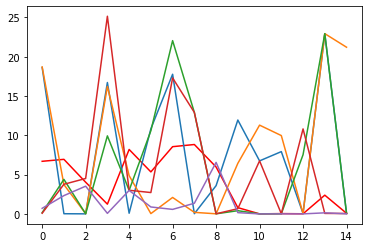

In [62]:
plt.plot(red, c='r')
rands = []
for k in range(4):
    indx = np.random.choice(range(11, len(X)), 11)
    rand = X.iloc[indx].std(0).values
    plt.plot(rand)
    rands.append(rand)

plt.plot(red/np.mean(rands, axis=0))

## Resource

* [PyGraphistry[AI]](http://github.com/graphistry/pygraphistryhttp://github.com/graphistry/pygraphistry)
  - Dashboarding with [graph-app-kit (containerized, gpu, graph Streamlit)](https://github.com/graphistry/graph-app-kit)
* [What is graph intelligence](https://gradientflow.com/what-is-graph-intelligence/https://gradientflow.com/what-is-graph-intelligence/)
* GNN Videos:
  * GCN - https://www.youtube.com/watch?v=2KRAOZIULzw
  * RGCN - https://www.youtube.com/watch?v=wJQQFUcHO5U
  * Euler (combining RNN + GNN)- https://www.youtube.com/watch?v=1t124vguwJ8